In [26]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'digit-recognizer:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F3004%2F861823%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20241012%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20241012T232630Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D49f097b710dc8ebf2a70355110986ce7d277fd2c12d49cdf7a56eef4f7b5602a5330c6ea417829e583897958d7c0f9eeabeea489fe389d883baca9f28b86be44864e39cd13df5bc73a0c3949a7e1cffd691c3fe0f0dae1fb6b5452147d71f3f1989ebb0d80e27ccb9960223bb31eda2ed0961b05af2bd12fefaf95f7db329606c126ce29d6367af8069945ed454bf0f1574fb34d08c5d2efb8d6872d9db8565526c706192be9bd55bf3dadca8b67ae70f5c70d8653cbb91a8afea4f79bb77b5c5ceb83046c04860ed599608b35a40c2ceba5247936adb49c82c17ac367aed0fc7287be0e4178aee8725f8b94e050468ffc832faafc6a34ccbac1ba85b1ff9790,machine-learning-architecture-diagrams:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F3438321%2F6163475%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20241012%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20241012T232630Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D7c7679ff001656fa0c834bf8ec981d142b4c6ac5289e3f2d52d40a4f48268c023ea2c5083edf85408ff8da3f9827f16fa18224b011fb5be82ffe7707990c86da73770dc7e949fb70f4742ff9488c1f1482f972441a205d63c983ed5b629ac085aba686510802b77d8e6dd5c7bd5254f607ddfc19dc8fe50314600b35019f40d5c17732ec46b75e157d46528948c2e4384ec995840b990422f4d35886a3ad22393a20505e2560ef68a780f08694a8cc2a88631e9e7e07ec1c8e5d2ad91de5ed5fcf526853bcc5f6042913ff843f0b3c4903aacff9a05da7a605d5d35fe34de851c5bcd60403523bf632ab6487fdffc0b1c1369947331633dbe4b7378d1b74262c'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 16054568 bytes downloaded
Downloaded and uncompressed: digit-recognizer
[==================================================] 153594 bytes downloaded
Downloaded and uncompressed: machine-learning-architecture-diagrams
Data source import complete.


In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from  torch.utils.data import DataLoader
from torchvision import datasets,transforms
import numpy as np
import matplotlib.pyplot as plt


In [31]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20) # mean
        self.fc22 = nn.Linear(400, 20) # variance
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1) # returns mean and variance

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add(mu) # returns sampled latent variable z

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3)) # returns reconstructed image

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [32]:
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [33]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

In [34]:
transform = transforms.Compose([transforms.ToTensor()])
train_set = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 35411943.73it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1113410.24it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 10902602.41it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2218273.03it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [38]:
import torch.optim as optim
model = VAE()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [39]:
for epoch in range(1, 10):
    train(model, train_loader, optimizer, epoch)

Train Epoch: 1 [0/60000 (0%)]	Loss: 549.715698
Train Epoch: 1 [12800/60000 (21%)]	Loss: 184.332901
Train Epoch: 1 [25600/60000 (43%)]	Loss: 153.798050
Train Epoch: 1 [38400/60000 (64%)]	Loss: 141.382492
Train Epoch: 1 [51200/60000 (85%)]	Loss: 132.982300
Train Epoch: 2 [0/60000 (0%)]	Loss: 123.340149
Train Epoch: 2 [12800/60000 (21%)]	Loss: 123.122635
Train Epoch: 2 [25600/60000 (43%)]	Loss: 122.725494
Train Epoch: 2 [38400/60000 (64%)]	Loss: 124.573517
Train Epoch: 2 [51200/60000 (85%)]	Loss: 118.008423
Train Epoch: 3 [0/60000 (0%)]	Loss: 118.008034
Train Epoch: 3 [12800/60000 (21%)]	Loss: 114.187881
Train Epoch: 3 [25600/60000 (43%)]	Loss: 113.233856
Train Epoch: 3 [38400/60000 (64%)]	Loss: 113.725060
Train Epoch: 3 [51200/60000 (85%)]	Loss: 112.520821
Train Epoch: 4 [0/60000 (0%)]	Loss: 108.992104
Train Epoch: 4 [12800/60000 (21%)]	Loss: 114.253174
Train Epoch: 4 [25600/60000 (43%)]	Loss: 115.845322
Train Epoch: 4 [38400/60000 (64%)]	Loss: 110.994942
Train Epoch: 4 [51200/60000 (85%

In [40]:
transform = transforms.Compose([transforms.ToTensor()])
test_set = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_set, batch_size=128, shuffle=True)

In [41]:
# assume that the trained VAE model is named 'vae_model'
# and the new dataset is loaded into a DataLoader named 'new_data_loader'

model.eval()
device = torch.device("cpu")
reconstruction_loss = nn.MSELoss(reduction='none')

total_loss = []
for batch_idx, (data, _) in enumerate(test_loader):
    data = data.to(device)
    recon_batch, mu, logvar = model(data)

    # compute reconstruction loss
    recon_loss =  loss_function(recon_batch, data, mu, logvar)


    loss = (recon_loss).item()
    total_loss.append(loss)

mean_loss = np.mean(total_loss)
std_loss = np.std(total_loss)

print("Mean loss: {:.3f}".format(mean_loss))
print("Standard deviation of loss: {:.3f}".format(std_loss))

Mean loss: 13410.031
Standard deviation of loss: 1372.978


In [44]:
model.eval()
image,_ = test_set.__getitem__(41)
with torch.no_grad():
    image = image.to(device)
    recon_image, mu, logvar = model(image.unsqueeze(-1))

    # compute reconstruction loss

    recon_loss = loss_function(recon_batch, data, mu, logvar)


print("Total loss: {:.3f}".format(recon_loss))

Total loss: 1221.454


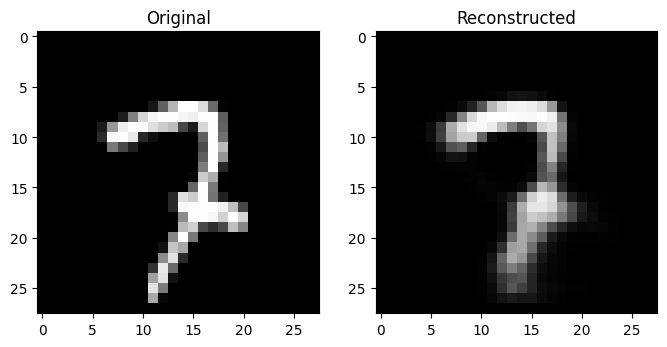

In [45]:
# convert the tensors to numpy arrays and reshape them into images
image = np.reshape(image.numpy(), (28, 28))
recon_image = np.reshape(recon_image.numpy(), (28, 28))

# display the original image and the reconstructed image side-by-side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
axes[0].imshow(image, cmap='gray')
axes[0].set_title("Original")
axes[1].imshow(recon_image, cmap='gray')
axes[1].set_title("Reconstructed")
plt.show()